In [1]:

# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]
table = str.maketrans('', '', string.punctuation)

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-02-24 10:37:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-02-24 10:37:52 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [6]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [7]:
training_size = 24000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20], input_shape=[], dtype=tf.string, trainable=False)

In [9]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [10]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [11]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs, validation_data=(testing_sentences, testing_labels), verbose=2)

Epoch 1/50
750/750 - 2s - loss: 0.6994 - accuracy: 0.5435 - val_loss: 0.6860 - val_accuracy: 0.5736
Epoch 2/50
750/750 - 1s - loss: 0.6759 - accuracy: 0.5838 - val_loss: 0.6704 - val_accuracy: 0.5980
Epoch 3/50
750/750 - 1s - loss: 0.6639 - accuracy: 0.6070 - val_loss: 0.6613 - val_accuracy: 0.6154
Epoch 4/50
750/750 - 1s - loss: 0.6566 - accuracy: 0.6215 - val_loss: 0.6553 - val_accuracy: 0.6283
Epoch 5/50
750/750 - 1s - loss: 0.6511 - accuracy: 0.6298 - val_loss: 0.6500 - val_accuracy: 0.6346
Epoch 6/50
750/750 - 1s - loss: 0.6467 - accuracy: 0.6346 - val_loss: 0.6459 - val_accuracy: 0.6405
Epoch 7/50
750/750 - 1s - loss: 0.6429 - accuracy: 0.6412 - val_loss: 0.6430 - val_accuracy: 0.6456
Epoch 8/50
750/750 - 1s - loss: 0.6397 - accuracy: 0.6442 - val_loss: 0.6401 - val_accuracy: 0.6515
Epoch 9/50
750/750 - 1s - loss: 0.6370 - accuracy: 0.6456 - val_loss: 0.6376 - val_accuracy: 0.6523
Epoch 10/50
750/750 - 1s - loss: 0.6345 - accuracy: 0.6498 - val_loss: 0.6367 - val_accuracy: 0.6512

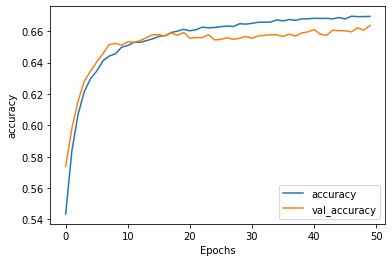

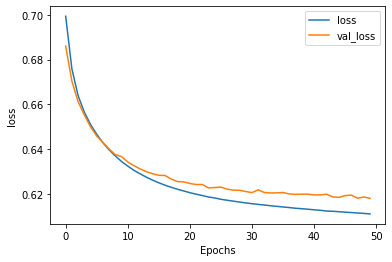

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
test_sentences = ["granny starting to fear spiders in the garden might be real", 
 "game of thrones season finale showing this sunday night", 
 "TensorFlow book will be a best seller"]

predictions = model.predict(test_sentences)

In [14]:

print(predictions)

[[0.60450435]
 [0.18563876]
 [0.49510828]]
